In [4]:
import pandas as pd
import numpy as np
import feather
import time
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import xgboost as xgb

from sklearn.metrics import silhouette_samples
from matplotlib import cm

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Deprecation warning will be ignored!


In [5]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

# Metrics used for measuring the accuracy and performance of the models
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Algorithms used for modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Metrics packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!


In [6]:
# count_df = pd.read_table('../data/Merged_Counts.tsv')
# feather.write_dataframe(count_df, '../data/adsc_Counts.feather')
# fpkm_df = pd.read_table('../data/Merged_FPKM.tsv')
# feather.write_dataframe(count_df, '../data/adsc_fpkm.feather')
# fpkm_uq_df = pd.read_table('../data/Merged_FPKM-UQ.tsv')
# feather.write_dataframe(count_df, '../data/adsc_uq_fpkm.feather')

In [7]:
clinical_df = pd.read_table('../data/LUNG_clinicalMatrix', index_col=0)
clinical_columns_dict = {
    'sampleID': 'tcga_id',
    '_primary_disease': 'primary',
#     'gender': 'gender',
#     'sample_type': 'tcga_type',
#     'Expression_Subtype': 'exp_sub',
}
clinical_df = clinical_df.filter(items=clinical_columns_dict.keys())
clinical_df = clinical_df.rename(columns=clinical_columns_dict)
clinical_df['primary'] = clinical_df['primary'].replace( {'lung adenocarcinoma': 'LUAD', 'lung squamous cell carcinoma': 'LUSC'} )
print(clinical_df.shape)
clinical_df.head()

(1299, 1)


,primary
sampleID,
TCGA-05-4244-01,LUAD
TCGA-05-4249-01,LUAD
TCGA-05-4250-01,LUAD
TCGA-05-4382-01,LUAD
TCGA-05-4384-01,LUAD


In [8]:
adsc_df = pd.read_feather('../data/adsc_Counts.feather')
adsc_df = adsc_df.drop(adsc_df.iloc[-5:, :].index, axis=0)
adsc_df = adsc_df.rename(columns={'Unnamed: 0': 'geneID'})
adsc_df = adsc_df.drop(['gene_name'], axis=1).set_index('geneID')
adsc_df.columns = [name[:15] for name in adsc_df.columns]
adsc_df = adsc_df.T.groupby(level=0).last() 
print(adsc_df.shape)
adsc_df.head()

(1124, 60483)


geneID,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000263980.4,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1
TCGA-05-4244-01,5027,0,1460,1500,867,1978,2983,4504,3129,3113,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4249-01,4415,0,2019,1891,519,1220,2758,3588,1582,6987,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4250-01,5355,5,2898,734,785,1484,4541,5274,2845,3697,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4382-01,3898,0,2832,1192,793,4687,8694,8710,5934,4073,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4384-01,1347,0,910,986,209,1053,1533,1696,6634,1272,...,0,0,0,0,0,0,0,0,0,0


# 値全体補正 + 列選択
### 1.値全体補正：MinMaxScaler
### 2.列選択 : geneごとに値が0の場合、半分以上を削除、MAD上位10000

In [9]:
adsc_mtx = MinMaxScaler().fit_transform(adsc_df.values)
adsc_minmax_df = pd.DataFrame(adsc_mtx, index=adsc_df.index, columns=adsc_df.columns)

In [10]:
no_name = [name for name in adsc_minmax_df.index if not name in clinical_df.index]
no_name

[]

In [11]:
del_list = [name for name in list(adsc_minmax_df.columns) if adsc_minmax_df[name].isin([0]).sum() > int(adsc_minmax_df.shape[0]/2)]
adsc_minmax_df.drop(del_list, axis=1, inplace=True)
print(adsc_minmax_df.shape)
adsc_minmax_df.head()

(1124, 32065)


geneID,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281855.1,ENSG00000281881.1,ENSG00000281883.1,ENSG00000281892.1,ENSG00000281896.1,ENSG00000281902.1,ENSG00000281903.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1
TCGA-05-4244-01,0.106701,0.00000,0.128714,0.255261,0.194291,0.111932,0.038515,0.189810,0.025400,0.112701,...,0.040650,0.333333,0.15,0.285714,0.206897,0.250,0.015330,0.121753,0.03125,0.126866
TCGA-05-4249-01,0.093407,0.00000,0.190001,0.331450,0.114180,0.068198,0.035450,0.146517,0.012470,0.278143,...,0.000000,0.085106,0.15,0.000000,0.142857,0.250,0.017689,0.032468,0.03125,0.007463
TCGA-05-4250-01,0.113826,0.00061,0.286372,0.106002,0.175414,0.083429,0.059741,0.226203,0.023026,0.137641,...,0.012195,0.042553,0.00,0.000000,0.091133,0.125,0.022406,0.038961,0.03125,0.022388
TCGA-05-4382-01,0.082177,0.00000,0.279136,0.195246,0.177256,0.268232,0.116322,0.388600,0.048844,0.153698,...,0.010163,0.007092,0.25,0.142857,0.142857,0.000,0.016509,0.094156,0.00000,0.111940
TCGA-05-4384-01,0.026762,0.00000,0.068414,0.155105,0.042818,0.058562,0.018760,0.057094,0.054695,0.034079,...,0.012195,0.166667,0.10,0.095238,0.068966,0.000,0.004717,0.030844,0.00000,0.007463


In [12]:
num_mad_genes = 10000
mad_genes = adsc_minmax_df.mad(axis=0).sort_values(ascending=False)
top_mad_genes = mad_genes.iloc[0:num_mad_genes, ].index
adsc_minmax_df = adsc_minmax_df.loc[:, top_mad_genes] 
print(adsc_minmax_df.shape)
adsc_minmax_df.head()

(1124, 10000)


geneID,ENSG00000266640.1,ENSG00000152413.13,ENSG00000139726.9,ENSG00000114999.7,ENSG00000126456.14,ENSG00000113460.11,ENSG00000132842.12,ENSG00000160194.16,ENSG00000281902.1,ENSG00000125952.17,...,ENSG00000104356.9,ENSG00000140950.14,ENSG00000225791.5,ENSG00000270248.1,ENSG00000157379.12,ENSG00000280374.1,ENSG00000163145.11,ENSG00000235703.4,ENSG00000111788.10,ENSG00000183171.5
TCGA-05-4244-01,0.500000,0.403692,0.350431,0.202607,0.663810,0.243815,0.596568,0.453983,0.250,0.343650,...,0.156208,0.093860,0.153995,0.068182,0.242595,0.400922,0.026618,0.494978,0.158537,0.305556
TCGA-05-4249-01,0.166667,0.098920,0.414984,0.201859,0.453363,0.111461,0.594314,0.295595,0.250,0.367291,...,0.132844,0.176931,0.214589,0.363636,0.205660,0.105991,0.080460,0.103300,0.020606,0.027778
TCGA-05-4250-01,0.000000,0.324277,0.404847,0.186471,0.240698,0.201416,0.410822,0.447235,0.125,0.387392,...,0.137294,0.172348,0.115014,0.045455,0.087421,0.299539,0.017241,0.040890,0.020185,0.013889
TCGA-05-4382-01,0.166667,0.364681,0.342504,0.491879,0.730059,0.150188,0.532315,0.402062,0.000,0.721905,...,0.159324,0.233076,0.279043,0.409091,0.127473,0.202765,0.077737,0.113343,0.259882,0.201389
TCGA-05-4384-01,0.166667,0.222222,0.123390,0.108784,0.154684,0.050791,0.208166,0.196626,0.000,0.144016,...,0.039608,0.092333,0.138942,0.045455,0.132630,0.156682,0.068361,0.065280,0.090833,0.090278


In [13]:
merge_df = pd.concat([adsc_minmax_df, clinical_df], axis=1, join_axes=[adsc_minmax_df.index])
adsc_minmax_df = merge_df.dropna(subset=['primary'])

In [30]:
y = adsc_minmax_df['primary'].map({'LUAD': 0, 'LUSC': 1}).values
test_df = adsc_minmax_df['primary'].map({'LUAD': 0, 'LUSC': 1})
train_df = adsc_minmax_df.drop(['primary'], axis=1)
X = adsc_minmax_df.drop(['primary'], axis=1).values

In [15]:
model = xgb.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

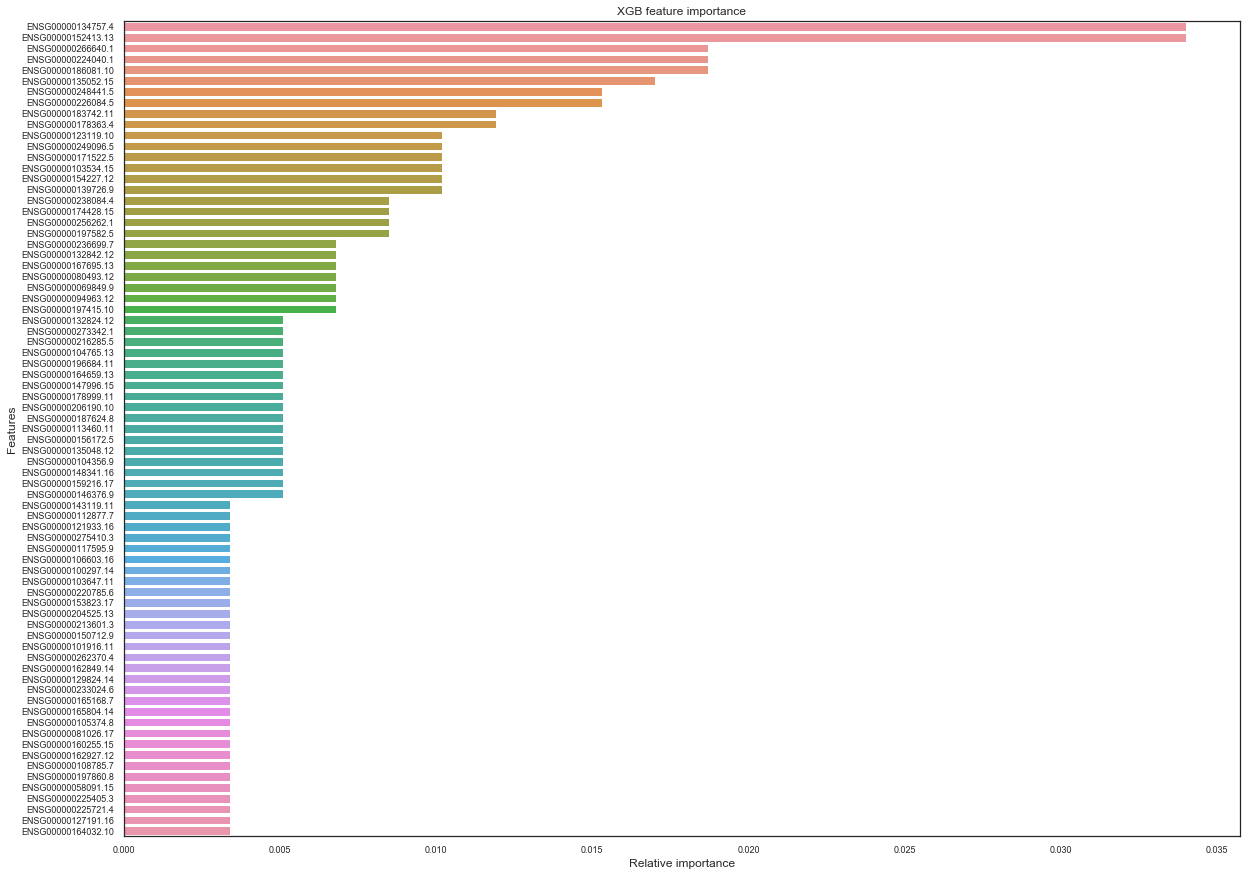

In [16]:
indice = np.argsort(model.feature_importances_)[::-1]
indice = indice[:75]

plt.subplots(figsize=(20, 15))
g = sns.barplot(y=adsc_minmax_df.columns[indice], x=model.feature_importances_[indice], orient='h')
g.set_xlabel('Relative importance', fontsize=12)
g.set_ylabel('Features', fontsize=12)
g.tick_params(labelsize=9)
g.set_title('XGB feature importance');

In [31]:
sss = StratifiedShuffleSplit(test_df, 10, test_size=0.2, random_state=23)
sss


StratifiedShuffleSplit(labels=[0 0 0 ... 1 0 1], n_iter=10, test_size=0.2, random_state=23)

In [32]:
len(train_df)

1124

In [34]:
len(test_df)

1124

In [35]:
for train_index, test_index in sss:
    X_train, X_test = train_df.values[train_index], train_df.values[test_index]
    y_train, y_test = test_df[train_index], test_df[test_index]

In [39]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 91.1111%
Log Loss: 1.938795993367709
SVC
****Results****
Accuracy: 51.1111%
Log Loss: 0.6957734563102818
NuSVC
****Results****
Accuracy: 88.4444%
Log Loss: 0.2600292465185156
DecisionTreeClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 3.837641821656743
RandomForestClassifier
****Results****
Accuracy: 90.2222%
Log Loss: 0.5265084068962881
AdaBoostClassifier
****Results****
Accuracy: 92.4444%
Log Loss: 0.5562296453207883
GradientBoostingClassifier
****Results****
Accuracy: 93.3333%
Log Loss: 0.1721075678250916
GaussianNB
****Results****
Accuracy: 84.8889%
Log Loss: 5.219192877895745
LinearDiscriminantAnalysis
****Results****
Accuracy: 90.6667%
Log Loss: 0.4968018068649697
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 53.7778%
Log Loss: 15.964589978092048


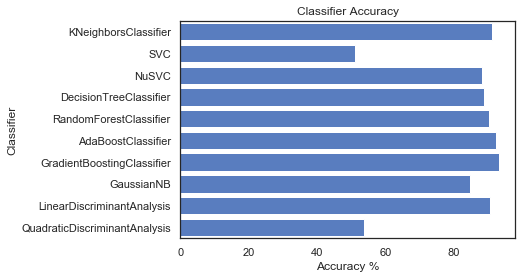

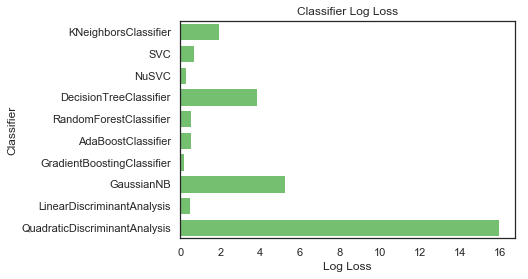

In [40]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()